import Importing neede libraries for preprocessing and model budiling 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import nltk
import io
import re
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk.tokenize import sent_tokenize
nltk.download('punkt') # one time execution
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
!pip install googletrans==3.1.0a0
from googletrans import Translator, constants
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import average_precision_score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 51kB 3.7MB/s 
     |████████████████████████████████| 1.0MB 6.5MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-cp37-none-any.whl size=16368 sha256=323badc1cc183e272f8e33f594267c7061b6e7ad87c5a70153f75bd5df83ac13
  Stored in directory: /root/.cache/pip/wheels/27/7a/a0/aff3babbb775549ce6813cb8fa7ff3c0848c4dc62c20f8fdac
Successfully built googletrans


In [2]:
#import of standford data set 
# this code was seperated from the main import block because it takes so long to run 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-04-30 15:07:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-30 15:07:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-30 15:07:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

read in dataset and look at it 

In [3]:
# this mehtod of reading in text works better for full text files 
# other method to read in articles 
txt = "/content/SpanishArticle.txt"

# opening and converting read in files to use able form 
txt = open(txt, "r")
text_sring_difLan = txt.read()
print(type(text_sring_difLan))
print(text_sring_difLan)
txt.close()


#Translate string into english
translator = Translator() #Google API translator
#Translates automatically from spanish to english, to translate differentlanguage, 
#translator.translate("Phrase", dest = "language code")
english = translator.translate(text_sring_difLan, dest = "en")
text_sring=english.text

<class 'str'>
Londres (CNN)– El organismo de control del gasto político de Gran Bretaña iniciará una investigación formal sobre la financiación de las renovaciones del departamento del primer ministro Boris Johnson en Downing Street, dado que se enfrenta a múltiples acusaciones de corrupción y escándalo político. La Comisión Electoral del Reino Unido dijo en un comunicado este miércoles que «hay motivos razonables para sospechar que puede haber un delito o delitos. Por lo tanto, continuaremos este trabajo como una investigación formal para establecer si este es el caso». Johnson ha sido presionado para que explique cómo pagó las remodelaciones de su departamento, que según los medios de comunicación británicos costaron alrededor de £ 200,000 (US$ 280,000). Los primeros ministros reciben £ 30,000 (US$ 41,000) de dinero público al año para renovar la propiedad durante su mandato. El líder del Reino Unido se enfrentó a un mayor escrutinio después de que su ex asesor principal lanzara acus

In [78]:

#remove stopwords from the sentences
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

# build word dictionary 
def dic_builder(file, dic ):
  for line in glo_file:
      line = line.split()
      values  = np.array(line[1:], dtype='float32')
      dic[line[0]] = values
  return dic 

# turn sentences into vecotrs 
def sen_vec(sentences, word_embeddings):
  vectors = []
  vec = 0 
  for i in sentences:
    if len(i) == 0:
      vec = np.zeros((200,))
    elif len(i) != 0:
      for word in i.split():
        vec = sum([word_embeddings.get(word, np.zeros((200,)))])/(len(sentence.split())+0.001)
    vectors.append(vec)
  return vectors 


def sentence_ranker(sentences, sentence_vectors, graph_out = False):
  sim_matrix = np.zeros([len(sentences), len(sentences)])
  for index_1 in range(len(sentences)):
    for index_2 in range(len(sentences)):
      if index_1 != index_2:
        sim_matrix[index_1][index_2] = cosine_similarity(sentence_vectors[index_1].reshape(1,200), sentence_vectors[index_2].reshape(1,200))[0,0]
  # converting scores to graph
  graph = nx.from_numpy_array(sim_matrix)
  scores = nx.pagerank(graph) 
  if graph_out == False:
    return sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True) 
  elif graph_out == True: 
    return graph



In [84]:
# build dictionary fo words vectors 
#word_embeddings = {}
#glo_file = open('glove.6B.200d.txt', encoding='utf-8')
#word_embeddings = dic_builder(glo_file, word_embeddings)
#glo_file.close()

# sentence clean up 
# remove punctuations, numbers and special characters.
sentences = text_sring.split('.') 
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
clean_sentences = [s.lower() for s in clean_sentences]
# remove stopwords from the sentences
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]
print(clean_sentences)

# sentence vectrorization 
sentence_vectors = sen_vec(clean_sentences,word_embeddings )

# ranking sentence with page rank 
ranked_sentences = sentence_ranker(sentences, sentence_vectors)
graph = sentence_ranker(sentences, sentence_vectors, graph_out = True)



['london cnn britain political spending watchdog launch formal investigation funding renovations prime minister boris johnson downing street apartment faces multiple allegations corruption political scandal', 'uk election commission said statement wednesday reasonable grounds suspect may crime crimes', 'therefore continue work formal investigation establish whether case', 'johnson pressured explain paid renovations apartment according british media cost around us', 'prime ministers receive us public money year renovate property tenure', 'uk leader faced increased scrutiny former senior adviser launched allegations unethical behavior last week', 'dominic cummings stepped role johnson former senior adviser late last year earning reputation advocate brexit policy prime minister election said blog post johnson planned make conservative party donors pay renewal', 'case loan would declared electoral commission', 'political grants loans strictly controlled uk loans us recorded publicly disclo

In [85]:
# output 
clound_sentences = " "  
cosSim=[]
print("the total number of sentences is", len(sentences))
print("the total number of sentences is", len(ranked_sentences))

# Extract top 5 sentences for word cloud
for i in range(0,5):
  print("--------------")
  print("ranked senctence number", i)
  print(ranked_sentences[i][0])
  print("cosine score" , ranked_sentences[i])
  clound_sentences += ranked_sentences[i][1]

#Extract cosine score for all sentences for graphical purposes:
for i in range(len(ranked_sentences)):
  cosSim.append(ranked_sentences[i][0])

the total number of sentences is 43
the total number of sentences is 43
--------------
ranked senctence number 0
0.0414744097366144
cosine score (0.0414744097366144, '" Johnson again denied that he made any such comments, despite multiple media reports citing anonymous sources this week')
--------------
ranked senctence number 1
0.0414744097366144
cosine score (0.0414744097366144, ' The UK leader faced increased scrutiny after his former senior adviser launched allegations of unethical behavior last week')
--------------
ranked senctence number 2
0.038547051674815376
cosine score (0.038547051674815376, ' Therefore, we will continue this work as a formal investigation to establish whether this is the case')
--------------
ranked senctence number 3
0.03758767119015214
cosine score (0.03758767119015214, '" CNN contacted the prime minister\'s office for his opinion on Wednesday')
--------------
ranked senctence number 4
0.03731347854645592
cosine score (0.03731347854645592, ' Political gra

(-0.5, 399.5, 199.5, -0.5)

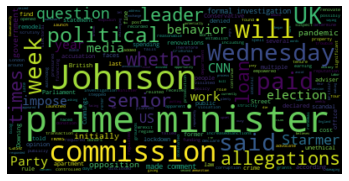

In [53]:
# word clounds for original text English
wordCloud = WordCloud().generate(text_sring)
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

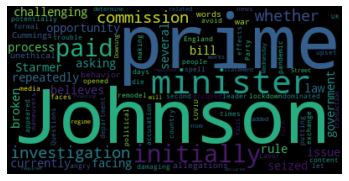

In [13]:
# clound for ranked sentences English
wordCloud = WordCloud().generate(clound_sentences)
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis("off")

In [14]:
translation = translator.translate(clound_sentences, dest = "es") #Change the last portion to the language the article originated from
print(f"{translation.origin} ({translation.src}) --> {translation.text}({translation.dest})")

  Starmer seized the opportunity, repeatedly challenging Johnson on the issue, asking the Prime Minister if he initially paid the bill and if he believes any rule or law was broken in the process The prime minister and his government are currently facing several allegations of unethical behavior, a war of words with Cummings, and a potentially very damaging accusation that Johnson was content to let people die to avoid putting England into a second lockdown" Questions about who initially paid for the department's remodel have dominated the UK media for days now, and the news that a formal investigation has been opened could spell further trouble for Johnson" The prime minister appeared upset, and at times angry, during the exchange and, in turn, accused the leader of the Labor Party of making political maneuvers as the country faces the effects of the COVID-19 pandemic The commission added in its statement on Wednesday that "the investigation will determine whether any transaction rela

(-0.5, 399.5, 199.5, -0.5)

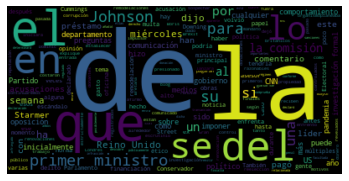

In [15]:
# word clounds for original text Different Language
wordCloud = WordCloud().generate(text_sring_difLan)
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

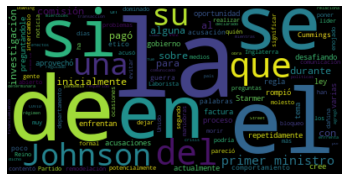

In [16]:
# clound for ranked sentences Different Language
wordCloud = WordCloud().generate(translation.text)
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis("off")

Text(0.5, 1.0, 'Cosine Similarity of All Sentences')

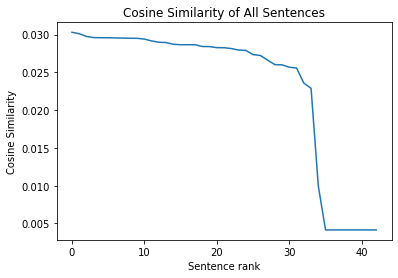

In [17]:
plt.plot(cosSim)
plt.xlabel("Sentence rank")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of All Sentences")

just scores from scores page rank 
[0.029517568478816845, 0.029411306290444566, 0.027915590470647764, 0.02842093324995728, 0.02866929705394689, 0.02899451627102798, 0.029591935346305318, 0.02796054954272186, 0.028430299617106584, 0.025686526944164054, 0.026037820064621523, 0.029521217909532032, 0.029593099101391816, 0.02976327715679561, 0.03012449659568959, 0.00995795702374797, 0.028662426958830433, 0.030319872509395707, 0.029566635466396277, 0.029613976545732047, 0.026632075122540247, 0.02735600490459378, 0.004143945327265755, 0.004143945327265755, 0.022898073136343258, 0.004143945327265755, 0.004143945327265755, 0.026000809075107344, 0.028953519752720473, 0.028163918051186895, 0.028268889065095237, 0.02866948725498264, 0.028725347192957496, 0.02955069162008857, 0.004143945327265755, 0.004143945327265755, 0.023589800398191807, 0.02724864001159166, 0.025583437607995835, 0.02828032919164029, 0.004143945327265755, 0.02916811239956623, 0.004143945327265755]
-------
cosin 
[0.0414744097366

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning:

invalid value encountered in true_divide



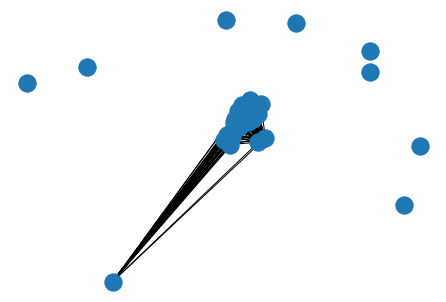

In [90]:

pagerank_scores = [scores[i] for i in range(len(scores)) ]
print("just scores from scores page rank ")
print(pagerank_scores)
print("-------")
print("cosin ")
print(cosSim)
# page rank and cosine have the same length so the true socres work for both 
true_socres  = np.zeros([len(cosSim)])
true_socres_1  = np.ones([len(cosSim)])
# average percision aganist page rank 
print("-------")

average_percision_1 = average_precision_score(true_socres_1, pagerank_scores)
average_percision_0 = average_precision_score(true_socres, pagerank_scores)
print("average percision when 0 are entered as ture response", average_percision_0)
print("average percision when 1 are entered as ture response", average_percision_1)

print("-------")
# average percision aganist cosine scores 
# average percsiion was not original built
average_percision_cosine_1 = average_precision_score(true_socres_1, cosSim)
average_percision__cosine_0 = average_precision_score(true_socres, cosSim)
print("average percision when 0 are entered as ture response", average_percision__cosine_0)
print("average percision when 1 are entered as ture response", average_percision_cosine_1)


print("-------")
print("graphy of simularity scores beore applying page rank ")
nx.draw(graph)
#A cosine value of 0 means that the two vectors are at 90 degrees 
#to each other (orthogonal) and have no match. The closer the cosine 
#value to 1, the smaller the angle and the greater the match between vectors. 
